# Overview

In this notebook, we are going to talks about `Hierarchial clustering`.


# Hierarchical clustering

Hierarchical clustering is a general family of clustering algorithms that build nested clusters by merging or splitting them succes-sively. This hierachy of clusters is represented as a tree (or dendrogram). The root of the tree is the unique cluster that gathers all the samples, the leaves being the clusters with only one sample.


# AgglomerativeClustering

The AgglomerativeClustering object performs a hierarchical clustering using a bottom up approach: each observation starts in its own cluster, and clusters are successively merged together. The linkage criteria determines the metric used for the merge strategy:

* **Ward** minimizes the sum of quared differences within all clusters. It is a variance-minimizing approach and in this sense is similar to the k-means objective function but tackled with an agglomerative hierarchical approach.
* **Maximum** or **complete linkage** minimizes the maximum distance between observation of pairs of clusters.
* **Average linkage** minimizes the average of the distances between all obervations of pairs of clusters.
* **Single linkage** minimizes the distance between the closest observations of pairs of clusters.


It can also scale to large number of samples when it is used jointly with a connectivity matrix, but is computationally expensive when no connectivity constraints are added between samples: it considers at each step all the possible merges.

# Comparing different hierarchical linkage methods on toy datasets

This example shows characteristics of differnt linkage methods for hierarchical clustering on datasets that are `interesting` but stull in 2D.

The main observations to make are:
* Single linkage is fast, and can perform well on non-globular data, but it performs poorly in the presences of noise.
* Average and complete linkage perform well on cleanly separated globular clusters, but have mixed results otherwise.
* Ward is the most effective method for noisy data.

While these examples give some intuition about the algorithms, this intuition might not apply to very high dimensional data.

# Generate datasets

We choose the size big rnough to seee the scalability of the algorithms, but not too big to avoid too long run-ning times.

In [1]:
from sklearn import cluster, datasets
import numpy as np

n_samples=1500
noisy_circles=datasets.make_circles(
    n_samples=n_samples,
    factor=0.5,
    noise=0.05,
    random_state=170
)

noisy_moons=datasets.make_moons(n_samples=n_samples, noise=0.05, random_state=170)
blobs=datasets.make_blobs(n_samples=n_samples, random_state=170)
rng=np.random.RandomState(170)
no_structure=rng.rand(n_samples,2), None

# Anisotropicly distributed data
X,y =datasets.make_blobs(n_samples=n_samples, random_state=170)
transformation=[[0.6,-0.6],[-0.4,0.8]]
X_aniso=np.dot(X, transformation)
aniso=(X_aniso,y)

# blobs with varied variances
varied=datasets.make_blobs(
    n_samples=n_samples,
    cluster_std=[1.0,2.5,0.5],
    random_state=170
)

# Run the clustering and plot

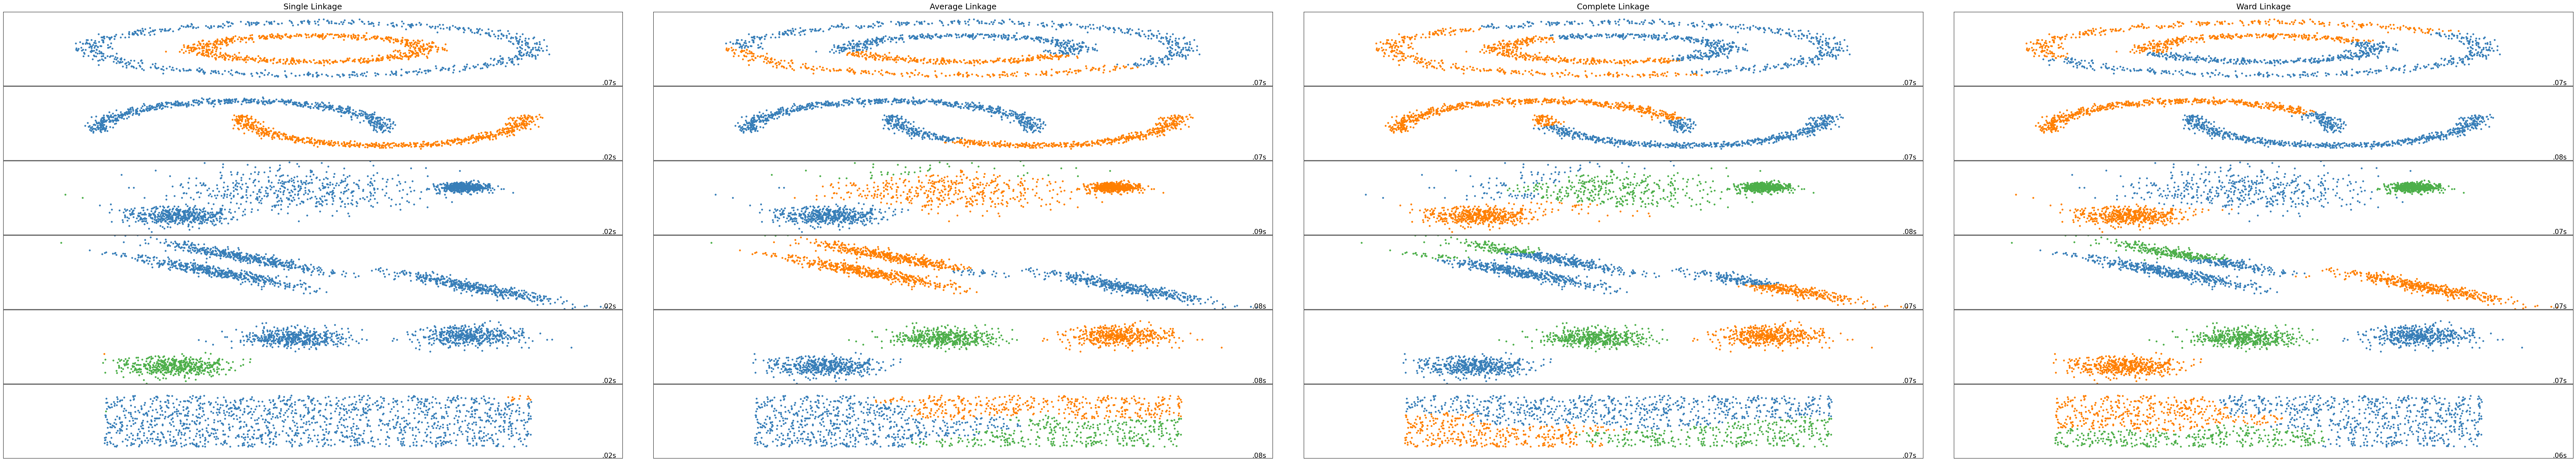

In [2]:
import time
import warnings

import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from itertools import cycle, islice

# Set up cluster parameters
plt.figure(figsize=(81.3+2,14.5))
plt.subplots_adjust(
    left=0.02, right=0.98, bottom=0.001, top=0.96, wspace=0.05, hspace=0.01
)

plot_num=1

default_base={'n_neightbors':10, 'n_clusters':3}

datasets=[
    (noisy_circles, {'n_clusters':2}),
    (noisy_moons, {'n_clusters':2}),
    (varied, {'n_neighbors':2}),
    (aniso, {'n_neighbors':2}),
    (blobs, {}),
    (no_structure, {}),
]

for i_dataset, (dataset, algo_params) in enumerate(datasets):
    # update parameters with dataset-specific values
    params=default_base.copy()
    params.update(algo_params)
    
    X,y=dataset
    
    # normalize dataset for easier parameter selection
    X=StandardScaler().fit_transform(X)
    
    #=========
    # Create cluster objects
    #=========
    ward=cluster.AgglomerativeClustering(
        n_clusters=params['n_clusters'], linkage='ward'
    )
    complete=cluster.AgglomerativeClustering(
        n_clusters=params['n_clusters'], linkage='complete'
    )
    average=cluster.AgglomerativeClustering(
        n_clusters=params['n_clusters'], linkage='average'
    )
    single=cluster.AgglomerativeClustering(
        n_clusters=params['n_clusters'], linkage='single'
    )
    
    clustering_algorithms=(
        ('Single Linkage', single),
        ('Average Linkage', average),
        ('Complete Linkage', complete),
        ('Ward Linkage', ward),
    )
    
    for name, algorithm in clustering_algorithms:
        t0=time.time()
        # catch warnings related to kneighbors_graph
        with warnings.catch_warnings():
            warnings.filterwarnings(
                'ignore', 
                message='the number of connected componenets of the'+'connectivity matrix is [0-9]{1,2}'+'>1.Completing it to avoid stopping the tree early.', 
                category=UserWarning
            )
            algorithm.fit(X)
        t1=time.time()
        if hasattr(algorithm, 'labels_'):
            y_pred=algorithm.labels_.astype(int)
        else:
            y_pred=algorithm.predict(X)
        plt.subplot(len(datasets), len(clustering_algorithms), plot_num)
        
        if i_dataset==0:
            plt.title(name, size=18)
        
        colors=np.array(list(islice(cycle([
            "#377eb8",
            "#ff7f00",
            "#4daf4a",
            "#f781bf",
            "#a65628",
            "#984ea3",
            "#999999",
            "#e41a1c",
            "#dede00",
        ]), int(max(y_pred)+1),)))
        
        plt.scatter(X[:,0],X[:,1], s=10, color=colors[y_pred])
        
        plt.xlim(-2.5, 2.5)
        plt.ylim(-2.5,2.5)
        plt.xticks(())
        plt.yticks(())
        plt.text(0.99,0.01,('%.2fs' % (t1-t0)).lstrip('0'), transform=plt.gca().transAxes, size=15, horizontalalignment='right')
        plot_num+=1

plt.show()            